In [1]:
%load_ext autoreload
%autoreload 2
from data_util import *
from metric_util import *
from train_util import *
from model import *

import torch 
import pickle
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"]="0"
import sys
sys.path.append('./PyGCL')
import GCL.losses as L
from GCL.models import DualBranchContrast
from GCL.eval import get_split, SVMEvaluator, LREvaluator


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
config = {
    'drop_prob': 0.2, 
    'cond_temp': 1.0/200,
    'debias_temp': 1.0/40,
    'debias_ratio': 2,
    'hidden_dim': 120,
    'conditional': False,
    'debias': False,
    'adversarial': False,
}

TASK_TYPE = 'classification'

In [3]:
dataset_adult = Adult(sens_name='gender') # x, y, s
x = dataset_adult[:][0]
sens = dataset_adult[:][2]
dataloader_adult = DataLoader(dataset_adult, batch_size=(1024*7), shuffle=True, num_workers=4)

In [4]:
input_dim = dataset_adult[0][0].shape[-1]
hidden_dim = config['hidden_dim']
sens_dim = dataset_adult.sens_dim

In [5]:
mlp_main = MLP(input_dim, hidden_dim)
mlp_sens = MLP(sens_dim, hidden_dim)
adv_model = Adv_sens(sens_num=2, hidden_dim=hidden_dim)

aug = FeatureDrop(drop_prob=config['drop_prob'])

encoder_model = Encoder(main_encoder = mlp_main, augmentor = aug, sens_encoder = mlp_sens, adv_model=adv_model)
encoder_model = encoder_model.to(device)

In [6]:
contrast_model = DualBranchContrast(loss=L.FairInfoNCE(tau=0.1), mode='G2G').to(device)
optim = Adam(encoder_model.parameters(), lr=0.001)

auc_list = []
hist_gdp_list = []
max_gdp_list = []

epoch = 1000
with tqdm(total=epoch, desc='(T)') as pbar:
    for epoch in range(1, epoch+1):
        encoder_model = encoder_model.to(device)
        loss_result = train(encoder_model = encoder_model, contrast_model=contrast_model,
                                         dataloader=dataloader_adult, optimizer = optim,
                                         conditional=True,debias=True, adversarial=False if epoch%5==0 else False,
                                         cond_temp = config['cond_temp'],
                                         debias_temp = config['debias_temp'],
                                         debias_ratio = config['debias_ratio'])
        pbar.set_postfix({'loss': loss_result['loss'], 
                          'conditional_loss':loss_result['conditional_loss'], 
                          'debias_loss': loss_result['debias_loss'],
                          'adv_loss': loss_result['adv_loss']})
        pbar.update()

        if epoch % 50 == 0:
            print(loss_result)
            result, evaluator = test(encoder_model, dataloader_adult, evaluator=LREvaluator(task=TASK_TYPE))
            print('auc: ', result['auc'])
            auc_list.append(result['auc'])
            classifier = result['classifier']
            hist_gdp = gdp(mode='hist', task=TASK_TYPE, hist_num=1000, x = x, sens = sens, encoder_model = encoder_model, classifier = classifier)
            print('hist gdp: ', hist_gdp)
            max_gdp = gdp(mode='max', task=TASK_TYPE, hist_num=1000, x = x, sens = sens, encoder_model = encoder_model, classifier = classifier)
            print('max gdp: ', max_gdp)
            kernel_gdp = gdp(mode='kernel', task=TASK_TYPE, hist_num=1000, x = x, sens = sens, encoder_model = encoder_model, classifier = classifier)
            print('kernel gdp: ', kernel_gdp)


(T):   0%|          | 0/1000 [00:00<?, ?it/s]


RuntimeError: expected scalar type Float but found Byte

In [90]:
import ray
from ray.tune import ExperimentAnalysis
from tsne_torch import TorchTSNE as TSNE

In [91]:
all_analysis = ExperimentAnalysis(experiment_checkpoint_path='/data/qf31/ray_results/adult/search_model_2022-05-10_19-44-54')
best_trial = all_analysis.get_best_trial(metric='auc_dp', mode='max', scope='all')
ckpt = all_analysis.get_best_checkpoint(trial=best_trial, metric='auc_dp', mode='max')
ckpt

<TrialCheckpoint local_path=/data/qf31/ray_results/adult/search_model_2022-05-10_19-44-54/search_model_92c60_00006_6_batch_size=2,cond_temp=0.037166,debias_ratio=2.0035,debias_temp=0.013451,drop_prob=0.20969,hidden_dim=1_2022-05-10_20-02-57/checkpoint_001500/, cloud_path=None>

In [92]:

model_state, optimizer_state,config = torch.load(os.path.join(ckpt, 'checkpoint'))

mlp_main = MLP(57, config['hidden_dim'])
mlp_sens = MLP(1,config['hidden_dim'])
aug = FeatureDrop(drop_prob=0.2)
encoder_model = Encoder(main_encoder = mlp_main, augmentor = aug, sens_encoder = mlp_sens)
encoder_model = encoder_model.to(device)

encoder_model.load_state_dict(model_state)
encoder_model.to(device)


Encoder(
  (main_encoder): MLP(
    (layers): Sequential(
      (0): Sequential(
        (0): Linear(in_features=57, out_features=120, bias=True)
        (1): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Linear(in_features=120, out_features=120, bias=True)
      )
      (1): Sequential(
        (0): Linear(in_features=120, out_features=120, bias=True)
        (1): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Linear(in_features=120, out_features=120, bias=True)
      )
    )
    (project_head): Sequential(
      (0): Linear(in_features=120, out_features=120, bias=True)
      (1): Linear(in_features=120, out_features=120, bias=True)
      (2): Linear(in_features=120, out_features=120, bias=True)
    )
  )
  (augmentor): FeatureDrop()
  (sens_encoder): MLP(
    (layers): Sequential(
      (0): Sequential(
        (0): Linear(in_features=1, out_features=

In [93]:
dataset_adult = Adult('./datasets/adult')
dataloader = DataLoader(dataset_adult, batch_size=2048*4, shuffle=True, num_workers=4)

result, evaluator = test(encoder_model, dataloader, evaluator=LREvaluator())
#print(result['auc'])
classifier = result['classifier']
x_0 = Adult('./datasets/adult', mode='male')[:][0]
x_1 = Adult('./datasets/adult', mode='female')[:][0]
dp = cls_dp(x_0, x_1, encoder_model, classifier)
print(' auc: ', result['auc'], ' dp: ', dp)

(LR): 100%|██████████| 500/500 [00:00<00:00, best test F1Mi=0.825, F1Ma=0.732]


14518
7189
0.18101666896266702
0.13437195715676728
 auc:  0.7144126374895606  dp:  0.04664471180589974


In [94]:
hidden_embed_0 = encoder_model.main_encoder.encode_project(x_0.to(device))[:1000]
hidden_embed_1 = encoder_model.main_encoder.encode_project(x_1.to(device))[:1000]
hidden_embed = torch.concat([hidden_embed_0, hidden_embed_1], dim=0).cpu().detach().numpy()

In [97]:
from sklearn.manifold import TSNE
from metric_util import _similarity
import matplotlib.pyplot as plt

In [96]:
tsne_embed = TSNE(n_components=2, perplexity=100,n_iter=2000, learning_rate='auto',init='random', verbose=True).fit_transform(hidden_embed)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.144s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 2.830492
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.084152
[t-SNE] KL divergence after 2000 iterations: 1.283685


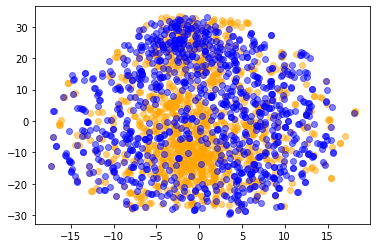

In [98]:
plt.scatter(tsne_embed[:1000, 0], tsne_embed[:1000, 1], c='orange', alpha=0.5, edgecolors='orange')
plt.scatter(tsne_embed[1000:, 0], tsne_embed[1000:, 1], c='blue', alpha=0.5, edgecolors='blue')

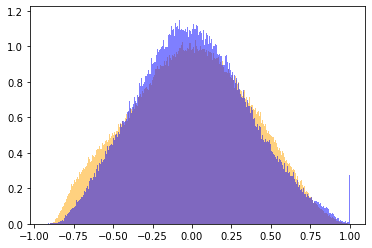

In [99]:
hidden_embed = torch.concat([hidden_embed_0, hidden_embed_1], dim=0)
dist_matrix = (_similarity(hidden_embed,hidden_embed)).detach().cpu().numpy()
n, bins, patches = plt.hist(dist_matrix[1000:, :1000].reshape(-1), bins=500, color='orange', density=True, alpha=0.5)
n, bins, patches = plt.hist(dist_matrix[1000:, 1000:].reshape(-1), bins=500, color='blue', density=True, alpha=0.5)

{'bodies': [<matplotlib.collections.PolyCollection at 0x7f54a13a4250>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f54a13a41f0>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f54a13a48e0>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f54a13a4ca0>}

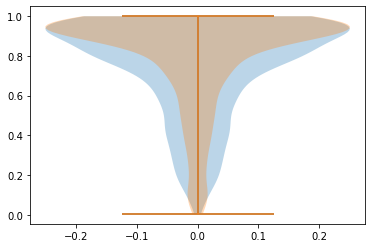

In [100]:
# pred hist
pred_prob = torch.nn.functional.softmax(classifier(hidden_embed), dim=1).detach().cpu().numpy()
plt.violinplot([pred_prob[:1000, 0]], [0])
plt.violinplot([pred_prob[1000:, 0]], [0])

In [3]:
import pandas as pd
import numpy as np

In [4]:
dataset_adult = Adult(sens_name='gender')

In [23]:
torch.sum(dataset_adult[:][1])

tensor(34014)

In [20]:
y

0        1
1        1
2        1
3        1
4        1
        ..
45217    1
45218    1
45219    1
45220    1
45221    0
Name: income_<=50K, Length: 45222, dtype: uint8

(array([7308., 8226., 8704., 8811., 5716., 3609., 2000.,  579.,  192.,
          77.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

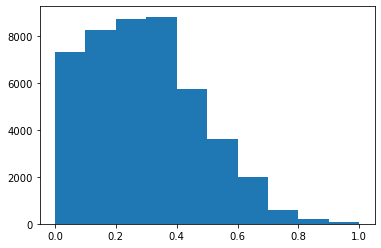

In [21]:
from matplotlib import pyplot as plt
plt.hist(s)

In [12]:
adult_df =  load_adult()

In [19]:
(adult_df.iloc[:, -2])

0        1
1        1
2        1
3        1
4        1
        ..
45217    1
45218    1
45219    1
45220    1
45221    0
Name: income_<=50K, Length: 45222, dtype: uint8